 
Data Model Used to solve the Scenarios 

![Screenshot%20from%202017-09-11%2022-05-30.png](attachment:Screenshot%20from%202017-09-11%2022-05-30.png "ShowMyImage")


Problem Scenario 1:
 
1.  Using sqoop, import orders table into hdfs to folders /user/cloudera/problem1/orders. File should be loaded as   
    Avro File and use snappy compression.
   
2.  Using sqoop, import order_items  table into hdfs to folders /user/cloudera/problem1/order-items. Files should be  
    loaded as avro file and use snappy compression
    
3.  Using Spark load data at /user/cloudera/problem1/orders and /user/cloudera/problem1/orders-items items as  
    dataframes. 
    
4.  Find total orders and total amount per status per day. The result should be sorted by order date in descending, 
    order status in ascending and total amount in descending and total orders in ascending. Aggregation should be 
    done using below methods. However, sorting can be done using a dataframe or RDD. Perform aggregation in each of 
    the following ways
        a). Just by using Data Frames API - here order_date should be YYYY-MM-DD format
        b). Using Spark SQL  - here order_date should be YYYY-MM-DD format
        c). By using combineByKey function on RDDS.
  
5.  Store the result as parquet file into hdfs using gzip compression under folder
        /user/cloudera/problem1/result4a-gzip
        /user/cloudera/problem1/result4b-gzip
        /user/cloudera/problem1/result4c-gzip
6.  Store the result as parquet file into hdfs using snappy compression under folder
        /user/cloudera/problem1/result4a-snappy
        /user/cloudera/problem1/result4b-snappy
        /user/cloudera/problem1/result4c-snappy
7.  Store the result as CSV file into hdfs using No compression under folder
        /user/cloudera/problem1/result4a-csv
        /user/cloudera/problem1/result4b-csv
        /user/cloudera/problem1/result4c-csv
    
8.  create a mysql table named result and load data from /user/cloudera/problem1/result4a-csv to mysql table named  
    
    result 

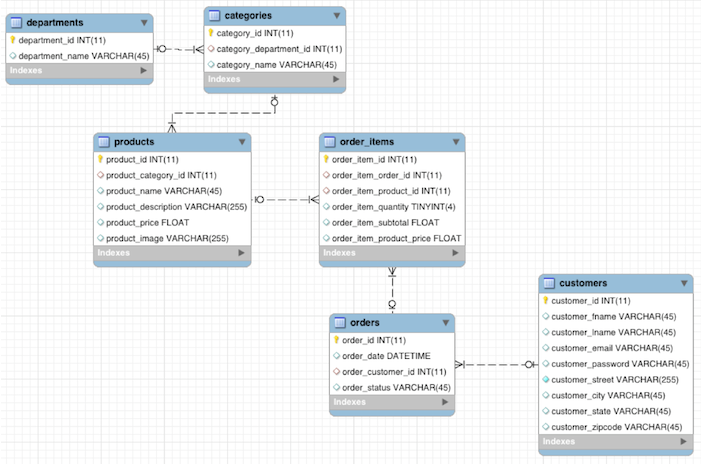

In [ ]:
## Sol 1:
sqoop import --connect "jdbc:mysql://nn01.itversity.com/retail_db"
--username retail_dba 
--password itversity 
--table orders 
--target-dir /user/abhishekparmanand158/problem1/orders 
--as-avrodatafile 
--compression-codec org.apache.hadoop.io.compress.SnappyCodec


## Sol 2:
sqoop import 
--connect "jdbc:mysql://nn01.itversity.com/retail_db" 
--username retail_dba
--password itversity 
--table order_items
--target-dir /user/abhishekparmanand158/problem1/order_items 
--as-avrodatafile 
--compression-codec org.apache.hadoop.io.compress.SnappyCodec

## Sol 3:
pyspark --packages com.databricks:spark-avro_2.10:2.0.1
import avro.schema

orders = sqlContext.read.format("com.databricks.spark.avro").load("/user/abhishekparmanand158/problem1/orders")

order_items  = sqlContext.read.format("com.databricks.spark.avro").load("/user/abhishekparmanand158/problem1/order_items")

## Sol 4a: 

DataFrame API

orders1 = orders.select(orders.order_id, from_unixtime(orders.order_date /1000, 'yyyy-MM-dd').alias("order_date1"), orders.order_customer_id, orders.order_status)
order_items.dtypes
ordersjoin = orders.join(order_items, orders.order_id == order_items.order_item_order_id)
orderjoin1 = ordersjoin.select( ordersjoin.order_date, ordersjoin.order_status, ordersjoin.order_id, 
                               ordersjoin.order_item_subtotal)
orderjoin1.select(orderjoin1.order_date, orderjoin1.order_status, orderjoin1.order_id).count()

orderdistinct = orderjoin1.select(orderjoin1.order_date, orderjoin1.order_status, orderjoin1.order_id).
                distinct().groupBy(orderjoin1.order_date, orderjoin1.order_status).count()

from pyspark.sql.functions import * ;

orderdistinct  = orderjoin1.select(orderjoin1.order_date, orderjoin1.order_status, orderjoin1.order_id, 
                        orderjoin1.order_item_subtotal).groupBy(orderjoin1.order_date, orderjoin1.order_status).
            agg(sum("order_item_subtotal").alias("total_amount") ,countDistinct("order_id").alias("total_orders"))
    
    
orderdistinctsort = orderdistinct.sort(orderdistinct.order_date.desc(), orderdistinct.order_status.asc(),
                                       orderdistinct.total_amount.desc(), orderdistinct.total_orders.asc())


## Sol 4b:

tablejoinq = sqlContext.sql("select from_unixtime(cast(t.order_date/1000 as int)) as order_date1, 
                            count(distinct t.order_id) as totalorder, t.order_status, 
                            sum(t.order_item_subtotal) as sum from tablejoin t group by 
                            order_date,order_status order by count(distinct t.order_id)")
                            
                            
                            
## Sol 4c:
                            
ordersRDD = sc.textFile("/user/cloudera/sqoop_import/orders")
orderItemsRDD = sc.textFile("/user/cloudera/sqoop_import/order_items")

ordersParsedRDD = ordersRDD.map(lambda rec: (int(rec.split(",")[0]), rec))
orderItemsParsedRDD = orderItemsRDD.map(lambda rec: (int(rec.split(",")[1]), rec))

ordersJoinOrderItems = orderItemsParsedRDD.join(ordersParsedRDD)
revenuePerOrderPerDay = ordersJoinOrderItems.map(lambda t: (t[1][1].split(",")[1], float(t[1][0].split(",")[4])))

ordersPerDay = ordersJoinOrderItems.map(lambda rec: rec[1][1].split(",")[1] + "," + str(rec[0])).distinct()
ordersPerDayParsedRDD = ordersPerDay.map(lambda rec: (rec.split(",")[0], 1))
totalOrdersPerDay = ordersPerDayParsedRDD.reduceByKey(lambda x, y: x + y)
                            
                            
                            
totalRevenuePerDay = revenuePerOrderPerDay.reduceByKey( \
lambda total1, total2: total1 + total2 \
)

for data in totalRevenuePerDay.collect():
  print(data)

# Joining order count per day and revenue per day
finalJoinRDD = totalOrdersPerDay.join(totalRevenuePerDay)
for data in finalJoinRDD.take(5):
print(data)
                            
                            
                        
## Sol 5

sqlContext.setConf("spark.sql.parquet.compression.codec", "snappy")

orderdistinctsort.write.parquet("/user/abhishekparmanand158/problem1/result4a-snappy")

sqlresult.write.parquet("/user/abhishekparmannad158/problem1/result4b-snappy")

## Sol 6

sqlContext.setConf("spark.sql.parquet.compression.codec", "gzip")

orderdistinctsort.write.parquet("/user/abhishekparmanand158/problem1/result4a-gzip")

sqlresult.write.parquet("/user/abhishekparmanand158/problem1/result4b-gzip")

## Sol 7

orderdistinctsort.map(lambda x: (str(x[0]) + "," + str(x[1]) + "," + str(x[2]) + "," + str(x[3]))).
      saveAsTextFile("/user/abhishekparmanand158/problem1/result4a-csv")
    
sqlresult.map(lambda x: (str(x[0]) + "," + str(x[1]) + "," + str(x[2]) + "," + str(x[3]))).
      saveAsTextFile("/user/abhishekparmanand158/problem1/result4b1-csv")

## Sol 8

sqoop export --connect "jdbc:mysql://nn01.itversity.com/retail_export" 
--username retail_dba
--password itversity
--table resultabhishek
--export-dir "/user/abhishekparmanand158/problem1/result4a-csv"
--input-fields-terminated-by ","


Problem Scenario 2:


1.  Using sqoop copy data available in mysql products table to folder /user/cloudera/products on hdfs as text file.  
    columns should be delimited by pipe '|'

2.  move all the files from /user/cloudera/products folder to /user/cloudera/problem2/products folder
    
3.  Change permissions of all the files under /user/cloudera/problem2/products such that owner has read,write and 
    execute permissions, group has read and write permissions whereas others have just read and execute permissions
    
4.  Read data in /user/cloudera/problem2/products and do the following operations using a) dataframes api b) spark 
    sql c) RDDs aggregateByKey method. Your solution should have three sets of steps. Sort the resultant dataset by 
    category id, filter such that your RDD\DF has products whose price is lesser than 100 USD
       
       1. on the filtered data set find out the higest value in the product_price column under each category
       2. on the filtered data set also find out total products under each category
       3. on the filtered data set also find out the average price of the product under each category
       4. on the filtered data set also find out the minimum price of the product under each category
    
5.  store the result in avro file using snappy compression under these folders respectively
        /user/cloudera/problem2/products/result-df
        /user/cloudera/problem2/products/result-sql
        /user/cloudera/problem2/products/result-rdd


In [ ]:
## Sol 1
sqoop import 
--connect "jdbc:mysql://nn01.itversity.com/retail_db" 
--username retail_dba 
--password itversity 
--table products 
--target-dir "/user/abhishekparmanand158/products" 
--as-textfile --fields-terminated-by "|"

## Sol 2
hadoop fs -cp /user/abhishekparmanand158/products /user/abhishekparmanand158/problem1/

## Sol 3
Hadoop fs –mv /user/abhishekparmanand158/products/user/abhishekparmanand158/problem1/products1

## Sol 4

products = sc.textFile("/user/cloudera/sqoop_import/products")
productsMap = products.map(lambda rec: (rec.split(",")[1], rec))
productsGroupBy = productsMap.groupByKey()
for i in productsGroupBy.collect(): print(i)

#Get data sorted by product price per category
#You can use map or flatMap, if you want to see one record per line you need to use flatMap
#Map will return the list
for i in productsGroupBy.map(lambda rec: sorted(rec[1], key=lambda k: float(k.split(",")[4]))).take(100): print(i)
for i in productsGroupBy.map(lambda rec: sorted(rec[1], key=lambda k: float(k.split(",")[4]), reverse=True)).take(100): print(i)

#To get topN products by price in each category
def getTopN(rec, topN):
  x = [ ]
  x = list(sorted(rec[1], key=lambda k: float(k.split(",")[4]), reverse=True))
  import itertools
  return (y for y in list(itertools.islice(x, 0, topN)))

for i in productsMap.groupByKey().flatMap(lambda x: getTopN(x, 2)).collect(): print(i)



## Data Frames:

from pyspark.sql import Row;
pythonschema = products.map(lambda x: Row(product_id = int(x.split("|")[0]), product_category_id 
             = int(x.split("|")[1]), product_name = x.split("|")[2], product_description = 
                x.split("|")[3], product_price = float(x.split("|")[4]), product_image = x.split("|")[5]))

productfiltered = sqlContext.createDataFrame(pythonschema)
productfiltered.registerTempTable("products")
productfiltered.show()

resultdataframe = productfiltered.filter(product_price < 100).groupBy(productfiltered.product_category_id).
                  agg(max(productfiltered.product_price).alias("maxpp"), countDistinct(productfiltered.product_id)
                  .alias("distinctpp"), mean(productfiltered.product_price).alias("averagepp"),
                  min(productfiltered.product_price).alias("mixpp")).sort(productfiltered.product_category_id.asc()).show()


## SQl

sqlresult = sqlContext.sql("select product_category_id, max(product_price) as maxpp, count(distinct product_id) 
            as productcount, avg(product_price) as avgpp, min(product_price) as minpp from 
            products where product_price < 100 group by product_category_id order by product_category_id " )
                           
## Sol 5
                           
sqlContext.setConf("spark.sql.parquet.compression.codec", "snappy")

sqlContext.setConf("spark.sql.com.databricks.spark.avro.compression.codec", "snappy")

sqlresult.write.save("/user/abhishekparmanand158/products/result1-sql", format="com.databricks.spark.avro")

resultdataframe.write.save("/user/abhishekparmanand158/products/result-dataframe", format="com.databricks.spark.avro")
                           
                           

Problem Scenario 3:

1.  Import all tables from mysql database into hdfs as avro data files. use compression and the compression codec 
    should be snappy. data warehouse directory should be retail_stage.db
    
2.  Create a metastore table that should point to the orders data imported by sqoop job above. Name the table 
    orders_sqoop. 
    
3.  Write query in hive that shows all orders belonging to a certain day. This day is when the most orders were 
    placed. select data from orders_sqoop. 
    
4.  query table in impala that shows all orders belonging to a certain day. This day is when the most orders were 
    placed. select data from order_sqoop. 
    
5.  Now create a table named retail.orders_avro in hive stored as avro, the table should have same table definition 
    as order_sqoop. Additionally, this new table should be partitioned by the order month i.e -> year-order_month.
    (example: 2014-01)
    
6.  Load data into orders_avro table from orders_sqoop table.
    
7.  Write query in hive that shows all orders belonging to a certain day. This day is when the most orders were 
    placed. 
    
    select data from orders_avro evolve the avro schema related to orders_sqoop table by adding more fields named   
    (order_style String, order_zone Integer)
    
8.  insert two more records into orders_sqoop table. 
    
9.  Write query in hive that shows all orders belonging to a certain day. This day is when the most orders were 
    placed. select data from orders_sqoop
    
10. query table in impala that shows all orders belonging to a certain day. This day is when the most orders were 
    placed. select data from orders_sqoop


In [ ]:
# Sol 1
sqoop import-all-tables \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--username retail_dba \
--password cloudera \
--warehouse-dir /user/hive/warehouse/retail_stage.db \
--compress \
--compression-codec snappy \
--as-avrodatafile
-m 1;

# Sol 2

hadoop fs -get /user/hive/warehouse/retail_stage.db/orders/part-m-00000.avro
avro-tools getschema part-m-00000.avro > orders.avsc
hadoop fs -mkdir /user/hive/schemas
hadoop fs -ls /user/hive/schemas/order
hadoop fs -copyFromLocal orders.avsc /user/hive/schemas/order

Launch HIVE using 'hive' command in a separate terminal

Below HIVE command will create a table pointing to the avro data file for orders data

create external table orders_sqoop
STORED AS AVRO
LOCATION '/user/hive/warehouse/retail_stage.db/orders'
TBLPROPERTIES ('avro.schema.url'='/user/hive/schemas/order/orders.avsc')

# Sol 3

Run this query in Hive. 


select * from orders_sqoop as X where X.order_date in 
 (select inner.order_date from (select Y.order_date, count(1) as total_orders 
  from orders_sqoop as Y group by Y.order_date order by total_orders desc, Y.order_date desc limit 1) inner);
    
# Sol 4

1. Run 'Invalidate metadata'
2. Run below query


select * from orders_sqoop as X where X.order_date in (select a.order_date from 
(select Y.order_date, count(1) as total_orders from orders_sqoop as Y group by Y.order_date 
                                   order by total_orders desc, Y.order_date desc limit 1) a);

# Sol 5 and 6

create database retail;

create table orders_avro
    > (order_id int,
    > order_date date,
    > order_customer_id int,
    > order_status string)
    > partitioned by (order_month string)
    > STORED AS AVRO;

insert overwrite table orders_avro partition (order_month)
select order_id, to_date(from_unixtime(cast(order_date/1000 as int))), order_customer_id, order_status, 
substr(from_unixtime(cast(order_date/1000 as int)),1,7) as order_month from default.orders_sqoop;

# Sol 7


1. hadoop fs -get /user/hive/schemas/order/orders.avsc
2. gedit orders.avsc

3.{
  "type" : "record",
  "name" : "orders",
  "doc" : "Sqoop import of orders",
  "fields" : [ {
    "name" : "order_id",
    "type" : [ "null", "int" ],
    "default" : null,
    "columnName" : "order_id",
    "sqlType" : "4"
  }, {
    "name" : "order_date",
    "type" : [ "null", "long" ],
    "default" : null,
    "columnName" : "order_date",
    "sqlType" : "93"
  }, {
    "name" : "order_customer_id",
    "type" : [ "null", "int" ],
    "default" : null,
    "columnName" : "order_customer_id",
    "sqlType" : "4"
  },{
    "name" : "order_style",
    "type" : [ "null", "string" ],
    "default" : null,
    "columnName" : "order_style",
    "sqlType" : "12"
  }, {
    "name" : "order_zone",
    "type" : [ "null", "int" ],
    "default" : null,
    "columnName" : "order_zone",
    "sqlType" : "4"
  }, {
    "name" : "order_status",
    "type" : [ "null", "string" ],
    "default" : null,
    "columnName" : "order_status",
    "sqlType" : "12"
  } ],
  "tableName" : "orders"
}

4. hadoop fs -copyFromLocal -f orders.avsc /user/hive/schemas/order/orders.avsc


# sol 8


insert into table orders_sqoop values (8888888,1374735600000,11567,"xyz",9,"CLOSED");
insert into table orders_sqoop values (8888889,1374735600000,11567,"xyz",9,"CLOSED");


# Sol 9

select * from orders_sqoop as X where X.order_date in (select inner.order_date from 
(select Y.order_date, count(1) as total_orders from orders_sqoop as Y group by Y.order_date 
 order by total_orders desc, Y.order_date desc limit 1) inner);


# Sol 10

 Lanch Impala shell by using command impala-shell

1. Run 'Invalidate metadata'
2. Run below query


select * from orders_sqoop as X where X.order_date in (select a.order_date from 
(select Y.order_date, count(1) as total_orders from orders_sqoop as Y group by Y.order_date 
 order by total_orders desc, Y.order_date desc limit 1) a);

Problem Scenario 4
    
    
1. Import orders table from mysql as text file to the destination /user/cloudera/problem5/text. Fields should be   
   terminated by a tab character ("\t") character and lines should be terminated by new line character ("\n"). 
    
2. Import orders table from mysql  into hdfs to the destination /user/cloudera/problem5/avro. File should be stored  
   as avro file.
   
3. Import orders table from mysql  into hdfs  to folders /user/cloudera/problem5/parquet. File should be stored as 
   parquet file.

3. Transform/Convert data-files at /user/cloudera/problem5/avro and store the converted file at the following 
   locations and file formats
    1. save data to hdfs using snappy compression as parquet file at /user/cloudera/problem5/parquet-snappy-Compress
    2. save the data to hdfs using gzip compression as text file at /user/cloudera/problem5/text-gzip-compress
    3. save the data to hdfs using no compression as sequence file at /user/cloudera/problem5/sequence
    4. save the data to hdfs using snappy compression as text file at /user/cloudera/problem5/text-snappy-compress

4. Transform/Convert data-files at /user/cloudera/problem5/parquet-snappy-compress and store the converted file at 
   the following locations and file formats
    1. save the data to hdfs using no compression as parquet file at /user/cloudera/problem5/parquet-no-compress
    2. save the data to hdfs using snappy compression as avro file at /user/cloudera/problem5/avro-snappy

5. Transform/Convert data-files at /user/cloudera/problem5/avro-snappy and store the converted file at the following 
   locations and file formats
    1. save the data to hdfs using no compression as json file at /user/cloudera/problem5/json-no-compress
    2. save the data to hdfs using gzip compression as json file at /user/cloudera/problem5/json-gzip

6. Transform/Convert data-files at  /user/cloudera/problem5/json-gzip and store the converted file at the following  
   locations and file formats
    1. save the data to as comma separated text using gzip compression at   /user/cloudera/problem5/csv-gzip
    
7. Using spark access data at /user/cloudera/problem5/sequence and stored it back to hdfs using no compression as 
   ORC file to HDFS to destination /user/cloudera/problem5/orc 


In [ ]:
# Sol 1
sqoop import --connect "jdbc:mysql://quickstart.cloudera:3306/retail_db"
--password cloudera 
--username retail_dba 
--table orders
--as-textfile 
--fields-terminated-by '\t'
--target-dir /user/cloudera/problem5/text -m 1

# sol 2

sqoop import --connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" 
--password cloudera 
--username retail_dba
--table orders
--as-avrodatafile
--target-dir /user/cloudera/problem5/avro -m 1

# Sol  3

sqoop import --connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" 
--password cloudera
--username retail_dba
--table orders
--as-parquetfile
--target-dir /user/cloudera/problem5/parquet -m 1

# Sol 4
sqlContext.setConf("spark.sql.avro.compression.codec", snappy)
import avro.schema

ordersavro = sqlContext.read.load("/user/abhishekparmanand158/new/problem4/avro", format = "com.databricks.spark.avro")
avro = sqlContext.read.format("com.databricks.spark.avro").load("/user/abhishekparmanand158/problem5/avro")
sqlContext.setConf("spark.sql.parquet.compression.codec", "snappy")
avro.write.save("/user/abhishekparmanand158/problem5/parquet-snappy-compress", format="parquet")

ordersavro.write.parquet("/user/abhishekparmanand158/new/problem4/parquet-snappy-compress")

avrordd = avro.rdd.map(list)
avrordd.saveAsTextFile("/user/abhishekparmanand158/problem5/text-gzip-compress", compressionCodecClass="org.apache.hadoop.io.compress.GzipCodec");

avrordd.saveAsTextFile("/user/abhishekparmanand158/problem5/text-snappy-compress", compressionCodecClass="org.apache.hadoop.io.compress.SnappyCodec");

avrordd.saveAsSequenceFile("/user/abhishekparmanand158/problem5/sequence1", compressionCodecClass="None")	

parquet = sqlContext.read.parquet("/user/abhishekparmanand158/problem5/parquet-snappy-compress")

parquet = sqlContext.read.format("parquet").load("/user/abhishekparmanand158/new/problem4/parquet-snappy-compress")

# Sol 5

sqlContext.setConf("spark.sql.parquet.compression.codec", "uncompressed")

parquet.write.parquet("/user/abhishekparmanand158/problem5/parquet-no-compress")

p.write.format("parquet").save("/user/abhishekparmanand158/new/problem4/parquet-no-compress1")

parquet.write.save("/user/abhishekparmanand158/problem5/avro-snappy", format="snappy")


parquet.write.format("com.databricks.spark.avro").save("/user/abhishekparmanand158/problem5/avro-snappy")

## Sol 6
avro = sqlContext.read.format("com.databricks.spark.avro").load("/user/abhishekparmanand158/problem5/avro-snappy")

avro.write.save("/user/abhishekparmanand158/problem5/json", format = "json")

jsonread = sqlContext.read.json("/user/abhishekparmanand158/problem5/json1")

jsonread1 = sqlContext.read.load("/user/abhishekparmanand158/problem5/json1", format = "json")

avro.toJSON().saveAsTextFile("/user/abhishekparmanand158/problem5/jsongzip", compressionCodecClass="org.apache.hadoop.io.compress.GzipCodec")

 # Sol 7
jsonread = sqlContext.read.json("/user/abhishekparmanand158/problem5/jsongzip")

jsonread.map(lambda x: (str(x[0]) + "," + str(x[1]) + "," + str(x[2]) + "," + str(x[3]))).saveAsTextFile("/user/abhishekparmanand158/problem5/csv-gzip", compressionCodecClass = "org.apache.hadoop.io.compress.GzipCodec")

sequence = sc.sequenceFile("/user/cloudera/problem4/sequence1", "org.apache.hadoop.io.Text"/IntWritable, "org.apache.hadoop.io.Text")


# Sol 8
get the file into local observe it

cut -c-300 part-00000

mm = sequence.map(lambda x: x[1])
mm.map(lambda x : x.split(",")).toDF()
PythonRDD[199] at RDD at PythonRDD.scala:43
orc1.write.format("orc").save("/user/cloudera/problem4/orc")

orcr = sqlContext.read.orc("/user/cloudera/problem4/orc")

Problem 5:

1. Using sqoop, import products_replica table from MYSQL into hdfs such that fields are separated by a '|' and lines   
   are separated by '\n'. Null values are represented as -1 for numbers and "NOT-AVAILABLE" for strings. Only 
   records with product id greater than or equal to 1 and less than or equal to 1000 should be imported and use 3 
   mappers for importing. The destination file should be stored as a text file to directory  /user/cloudera/problem5
   /products-text. 
   
2. Using sqoop, import products_replica table from MYSQL into hdfs such that fields are separated by a '*' and lines 
   are separated by '\n'. Null values are represented as -1000 for numbers and "NA" for strings. Only records with 
   product id less than or equal to 1111 should be imported and use 2 mappers for importing. The destination file   
   should be stored as a text file to directory  /user/cloudera/problem5/products-text-part1. 
   
3. Using sqoop, import products_replica table from MYSQL into hdfs such that fields are separated by a '*' and lines 
   are separated by '\n'. Null values are represented as -1000 for numbers and "NA" for strings. Only records with 
   product id greater than 1111 should be imported and use 5 mappers for importing. The destination file should be 
   stored as a text file to directory  /user/cloudera/problem5/products-text-part2.
   
4. Using sqoop merge data available in /user/cloudera/problem5/products-text-part1 and /user/cloudera/problem5
   /products-text-part2 to produce a new set of files in /user/cloudera/problem5/products-text-both-parts
   
5. Using sqoop do the following. Read the entire steps before you create the sqoop job.
   create a sqoop job Import Products_replica table as text file to directory /user/cloudera/problem5/products-
   incremental. Import all the records.
        1. insert three more records to Products_replica from mysql
        2. run the sqoop job again so that only newly added records can be pulled from mysql
        3. insert 2 more records to Products_replica from mysql
        4. run the sqoop job again so that only newly added records can be pulled from mysql
        5. Validate to make sure the records have not be duplicated in HDFS
    
6. Using sqoop do the following. Read the entire steps before you create the sqoop job.
        
   1. create a hive table in database named problem5 using below command 
   2. create table products_hive  (product_id int, product_category_id int, product_name string, product_description 
       string, product_price float, product_imaage string,product_grade int,  product_sentiment string);
   3. create a sqoop job Import Products_replica table as hive table to database named problem5. name the table as 
      products_hive. 
        
   4. insert three more records to Products_replica from mysql
   5. run the sqoop job again so that only newly added records can be pulled from mysql
   6. insert 2 more records to Products_replica from mysql
   7. run the sqoop job again so that only newly added records can be pulled from mysql
   8. Validate to make sure the records have not been duplicated in Hive table
    
7. Using sqoop do the following. 
        
   1. insert 2 more records into products_hive table using hive. 
   2. create table in mysql using below command   
   3. create table products_external  (product_id int(11) primary Key, product_grade int(11), product_category_id 
      int(11), product_name varchar(100), product_description varchar(100), product_price float, product_impage 
      varchar(500), product_sentiment varchar(100));
        
8. export data from products_hive (hive) table to (mysql) products_external table. 
        1. insert 2 more records to Products_hive table from hive
        2. export data from products_hive table to products_external table. 
        3. Validate to make sure the records have not be duplicated in mysql table


In [ ]:
# Sol 1

sqoop import \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--username retail_dba \
--password cloudera \
--table products_replica \
--target-dir /user/cloudera/problem5/products-text \
--fields-terminated-by '|' \
--lines-terminated-by '\n' \
--null-non-string -1 \
--null-string "NOT-AVAILABLE" \
-m 3 \
--where "product_id between 1 and 1000" \
--outdir /home/cloudera/sqoop1 \
--boundary-query "select min(product_id), max(product_id) from products_replica where product_id between 1 and 1000";

# Sol 2

sqoop import \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--username retail_dba \
--password cloudera \
--table products_replica \
--target-dir  /user/cloudera/problem5/products-text-part1  \
--fields-terminated-by '*' \
--lines-terminated-by '\n' \
--null-non-string -1000 \
--null-string "NA" \
-m 2 \
--where "product_id <= 1111 " \
--outdir /home/cloudera/sqoop2 \
--boundary-query "select min(product_id), max(product_id) from products_replica where product_id <= 1111";

# Sol 3

sqoop import \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--username retail_dba \
--password cloudera \
--table products_replica \
--target-dir  /user/cloudera/problem5/products-text-part2  \
--fields-terminated-by '*' \
--lines-terminated-by '\n' \
--null-non-string -1000 \
--null-string "NA" \
-m 5 \
--where "product_id > 1111 " \
--outdir /home/cloudera/sqoop3 \
--boundary-query "select min(product_id), max(product_id) from products_replica where product_id > 1111"

# Sol 4
sqoop merge \
--class-name products_replica \
--jar-file mp/sqoop-cloudera/compile/66b4f23796be7625138f2171a7331cd3/products_replica.jar \
--new-data /user/cloudera/problem5/products-text-part2 \
--onto /user/cloudera/problem5/products-text-part1 \
--target-dir /user/cloudera/problem5/products-text-both-parts \
--merge-key product_id;

# Sol 5


## On terminal -

sqoop job --create first_sqoop_job \
-- import \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--username "retail_dba" \
--password "cloudera" \
--table products_replica \
--target-dir /user/cloudera/problem5/products-incremental \
--check-column product_id \
--incremental append \
--last-value 0;

sqoop job --exec first_sqoop_job

On MySQL command line -

mysql> insert into products_replica values (1346,2,'something 1','something 2',300.00,'not avaialble',3,'STRONG');
mysql> insert into products_replica values (1347,5,'something 787','something 2',356.00,'not avaialble',3,'STRONG');

## On terminal - 

sqoop job --exec first_sqoop_job

On MYSQL Command Line

insert into products_replica values (1376,4,'something 1376','something 2',1.00,'not avaialble',3,'WEAK');
insert into products_replica values (1365,4,'something 1376','something 2',10.00,'not avaialble',null,'NOT APPLICABLE');

## On terminal - 

sqoop job --exec first_sqoop_job

# Sol 6

 ## On Terminal window-

sqoop job \
--create hive_sqoop_job \
-- import \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--username "retail_dba" \
--password "cloudera" \
--table products_replica  \
--check-column product_id \
--incremental append \
--last-value 0 \
--hive-import \
--hive-table products_hive \
--hive-database problem5;

## On Hive window:

create database problem5;

 ##use problem5;

create table products_hive  (product_id int, product_category_id int, product_name string, product_description string, product_price float, product_imaage string,product_grade int,  product_sentiment string);

## On Terminal window

sqoop job --exec hive_sqoop_job

## On MySQL window

insert into products_replica values (1378,4,'something 1376','something 2',10.00,'not avaialble',null,'NOT APPLICABLE');
insert into products_replica values (1379,4,'something 1376','something 2',10.00,'not avaialble',null,'NOT APPLICABLE');

## On Terminal Window

sqoop job --exec hive_sqoop_job

## On Hive Window

select * from products_hive


# Sol 7

 ## On Hive Window

## use problem5;

insert into table products_hive values (1380,4,'something 1380','something 2',8.00,'not avaialble',3,'NOT APPLICABLE');

insert into table products_hive values (1381,4,'something 1380','something 2',8.00,'not avaialble',3,'NOT APPLICABLE');

## On MYSQL window

create table products_external  (product_id int(11) primary Key, product_grade int(11), product_category_id int(11), product_name varchar(100), product_description varchar(100), product_price float, product_impage varchar(500), product_sentiment varchar(100));

## On Terminal 

sqoop export \
--username "retail_dba" \
--password "cloudera" \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
 --export-dir /user/hive/warehouse/problem5.db/products_hive/ \
--input-fields-terminated-by '\001' \
--input-null-non-string "null" \
--input-null-string "null" \
--update-mode allowinsert \
--update-key product_id \
--columns "product_id,product_category_id,product_name,product_description,product_price,product_impage,product_grade,product_sentiment" --table products_external;

## On Hive Window 

insert into table products_hive values (1382,4,'something 1380','something 2',8.00,'not avaialble',3,'NOT APPLICABLE');

insert into table products_hive values (1383,4,'something 1380','something 2',8.00,'not avaialble',3,'NOT APPLICABLE');

## On Terminal Window:

sqoop export \
--username "retail_dba" \
--password "cloudera" \
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db" \
--export-dir /user/hive/warehouse/problem5.db/products_hive/ \
--input-fields-terminated-by '\001' \
--input-null-non-string "null" \
--input-null-string "null" \
--update-mode allowinsert \
--update-key product_id \
--columns "product_id,product_category_id,product_name,product_description,product_price,product_impage,product_grade,product_sentiment" --table products_external;

##To Validate
## On Hive
select count(*) from problem5.products_hive;
on MySQL
select count(*) from products_replica;

Problem Scenario 6:

1.  create a hive meta store database named problem6 and import all tables from mysql retail_db database into hive 
    meta store. 
  
2.  On spark shell use data available on meta store as source and perform step 3,4,5 and 6.

3.  Rank products within department by price and order by department ascending and rank descending
   
4.  find top 10 customers with most unique product purchases. if more than one customer has the same number of 
    product purchases then the customer with the lowest customer_id will take precedence 
    
5.  On dataset from step 3, apply filter such that only products less than 100 are extracted 
    
6.  On dataset from step 4, extract details of products purchased by top 10 customers which are priced at less than 
    100 USD per unit 
    
7.  Store the result of 5 and 6 in new meta store tables within hive.

In [ ]:
# Sol 1

sqoop import-all-tables 
--connect "jdbc:mysql://quickstart.cloudera:3306/retail_db"
--username retail_dba
--password cloudera 
--warehouse-dir /user/hive/warehouse/problem6.db
--hive-import
--hive-database problem6
--create-hive-table --as-textfile;

# Sol 2

var hc = new org.apache.spark.sql.hive.HiveContext(sc);

# Sol 3

hiveResult      = hc.sql("select   d.department_id,   p.product_id,   p.product_name,  p.product_price,  
                        rank() over (partition by d.department_id order by p.product_price) as product_price_rank, 
                        dense_rank() over (partition by d.department_id order by p.product_price) 
                        as product_dense_price_rank   from products p 
                        inner join categories c on c.category_id = p.product_category_id
                        inner join departments d on c.category_department_id = d.department_id 
                        order by d.department_id, product_price_rank desc, product_dense_price_rank ");
                         
                         
# Sol 4
                         
hiveResult2 = hc.sql("select c.customer_id, c.customer_fname, count(distinct(oi.order_item_product_id)) 
                     unique_products  from customers c   inner join orders o on 
                     o.order_customer_id = c.customer_id  inner join order_items oi on 
                     o.order_id = oi.order_item_order_id  group by c.customer_id, c.customer_fname 
                     order by unique_products desc, c.customer_id   limit 10")
                    
                     
                     
# Sol 5

hiveResult.registerTempTable("product_rank_result_temp");
hc.sql("select * from product_rank_result_temp where product_price < 100").show();
                     
                     
# Sol 6
topCustomers = hc.sql("select c.customer_id, c.customer_fname, count(distinct(oi.order_item_product_id)) 
                      unique_products  from customers c   inner join orders o
                      on o.order_customer_id = c.customer_id  inner join order_items oi 
                      on o.order_id = oi.order_item_order_id  
                      group by c.customer_id, c.customer_fname
                      order by unique_products desc, c.customer_id   limit 10  ");

topCustomers.registerTempTable("top_cust");

topProducts = hc.sql("select distinct p.* from products p inner join order_items oi on 
                     oi.order_item_product_id = p.product_id inner join orders o on 
                     o.order_id = oi.order_item_order_id inner join top_cust tc on
                     o.order_customer_id = tc.customer_id where p.product_price < 100");
                     
                     
# Sol 7:
                     
hc.sql("create table problem6.product_rank_result as select * from product_rank_result_temp 
        where product_price < 100");
hc.sql("create table problem 6.top_products as select distinct p.* from products p inner join 
       order_items oi on oi.order_item_product_id = p.product_id inner join orders o 
       on o.order_id = oi.order_item_order_id inner join top_cust tc on
       o.order_customer_id = tc.customer_id where p.product_price < 100");

